In [1]:
from train_config import ModelHandler
import torch
import torch.nn as nn
import mlflow.pytorch
import mlflow
import os
import tiktoken
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm

enc = tiktoken.get_encoding("gpt2")


logged_model = 'runs:/0dd2b64253584cd39c52fc1482c035ae/mtn_359'
nanoGPT = mlflow.pytorch.load_model(logged_model, map_location=torch.device('cpu'))
nanoGPT = nanoGPT.to('cpu')

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024/01/05 17:15:34 WARNING mlflow.pytorch: Stored model version '2.0.0' does not match installed PyTorch version '2.1.2+cu121'


In [51]:
vocab_tc = nanoGPT.sequence_encoder.vocabolary_enconding_tc.weight
vocab_tc = vocab_tc.detach().numpy()
vocab_tc.shape

(50256, 36)

torch.Size([12, 3, 3])
0th head
1th head
2th head
3th head
4th head
5th head
6th head
7th head
8th head
9th head
10th head
11th head


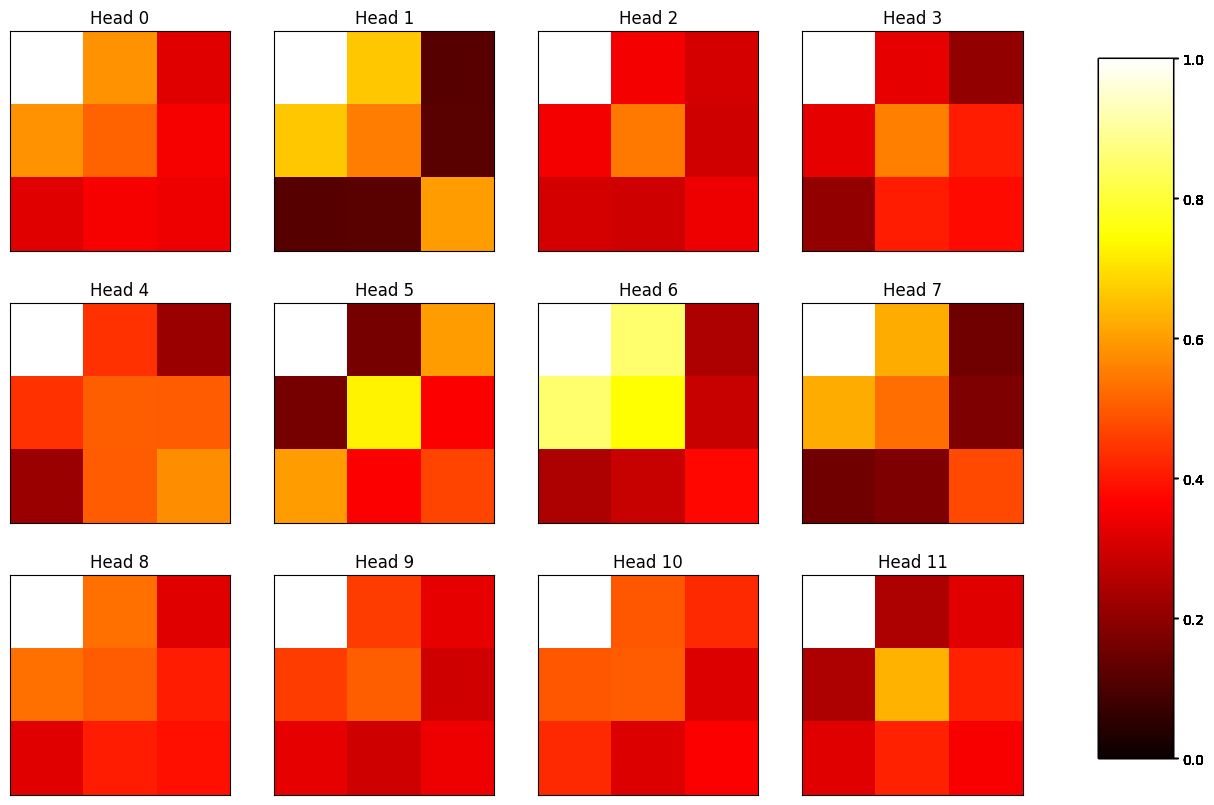

In [46]:
import matplotlib.pyplot as plt

import math
self = nanoGPT.transformer_blocks[4].self_attention
pre_metric_tensors_nkk = self.pre_metric_tensors_nkk.masked_fill(self.MASK_11ww[:,:,:self.K_DIMENSION,:self.K_DIMENSION] == 0, float('-inf'))
pre_metric_tensors_nkk = F.softmax(pre_metric_tensors_nkk / math.sqrt(self.K_DIMENSION), dim=-1)
M = pre_metric_tensors_nkk @ pre_metric_tensors_nkk.transpose(-1, -2)  # ensures symmetry and positive definiteness
M = M[0]
print(M.shape)
# plt of all  12 M side by side
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
for i in range(3):
    for j in range(4):
        print(f"{i*4+j}th head")


        # eucledian norm to each 
        H = M[i*4+j].detach().numpy()
        # H = H / np.linalg.norm(H, axis=0)



        # axs[i, j].imshow(H)
        axs[i, j].set_title(f"Head {i*4+j}")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        # the possible cmap values are here:
        # https://matplotlib.org/stable/tutorials/colors/colormaps.html
        fig.colorbar(axs[i, j].imshow(H, cmap="hot", vmin=0, vmax=1), cax=cbar_ax)


fig.subplots_adjust(right=0.8)

plt.show()


40
49


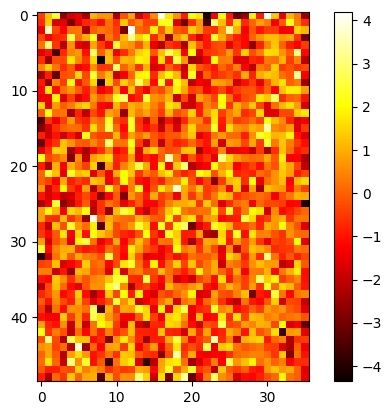

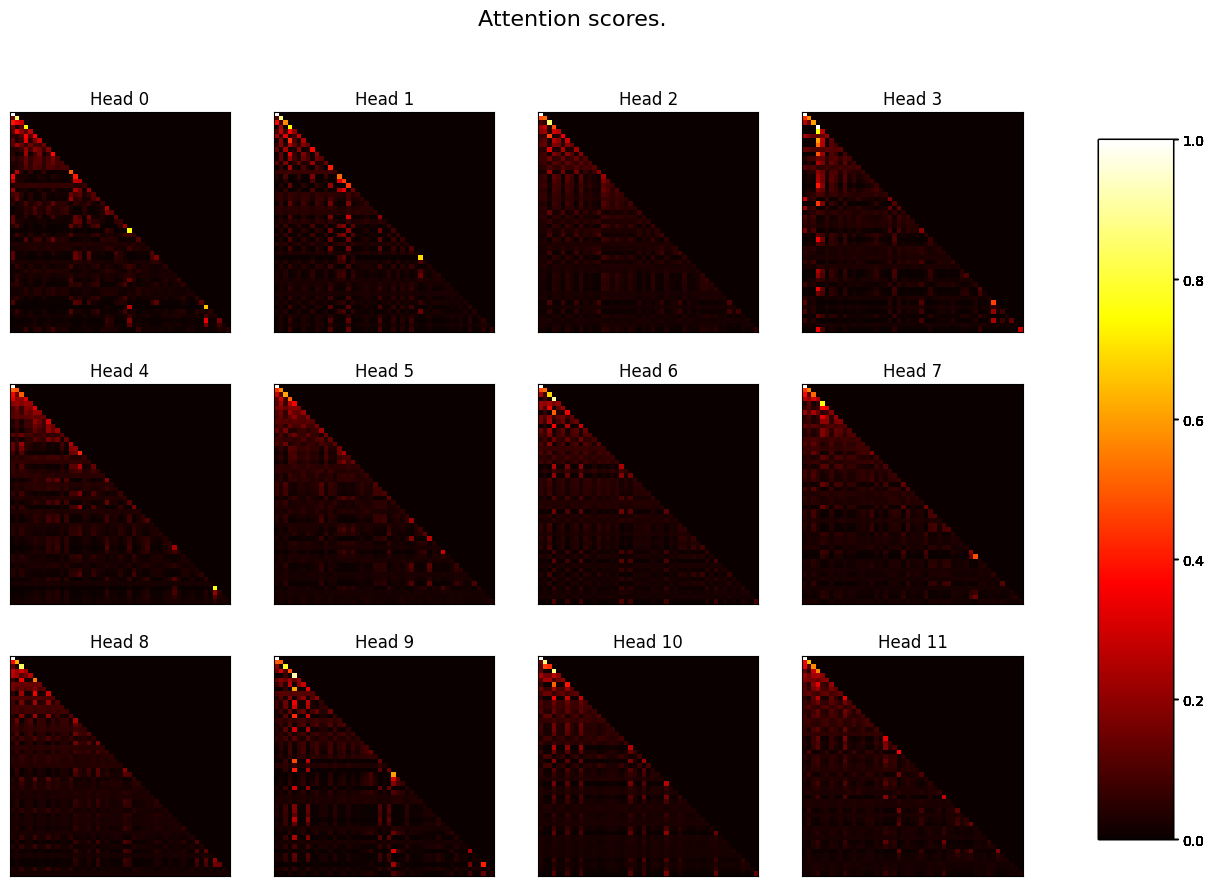

In [63]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import math
self = nanoGPT.transformer_blocks[0].self_attention
pre_metric_tensors_nkk = self.pre_metric_tensors_nkk.masked_fill(self.MASK_11ww[:,:,:self.K_DIMENSION,:self.K_DIMENSION] == 0, float('-inf'))
pre_metric_tensors_nkk = F.softmax(pre_metric_tensors_nkk / math.sqrt(self.K_DIMENSION), dim=-1)
metric_tensors_nkk = pre_metric_tensors_nkk @ pre_metric_tensors_nkk.transpose(-1, -2)  # ensures symmetry and positive definiteness

# plt of all  12 M side by side







sequence_s = "As you wish. Sit down. Sit down. Father, I wish to to continue to do that. The ring is still in the pocket. And I want to keep it, for my own. And that marks the end of the story." 
print(len(sequence_s.split(" ")))
sequence_s = enc.encode(sequence_s)
print(len(sequence_s))
sequence_1s = torch.tensor([sequence_s], dtype=torch.long, device='cpu')
sequence_1sc = nanoGPT.sequence_encoder(sequence_1s)
plt.imshow(sequence_1sc[0].detach().numpy(), cmap="hot")
plt.colorbar()

batch, words, coordinates = sequence_1sc.size()

all_projections_bwc = self.projections_cc(sequence_1sc)
all_projections_bnwk = all_projections_bwc.view(batch, words, self.NUMBER_OF_HEADS, self.K_DIMENSION).transpose(1, 2)

all_dot_products_bnww = all_projections_bnwk @ metric_tensors_nkk @ all_projections_bnwk.transpose(-1, -2)
all_dot_products_bnww = all_dot_products_bnww / math.sqrt(self.K_DIMENSION)
all_dot_products_bnww = all_dot_products_bnww.masked_fill(self.MASK_11ww[:,:,:words,:words] == 0, float('-inf'))
all_dot_products_bnww = F.softmax(all_dot_products_bnww, dim=-1)


# sequence_sc = vocab_tc[1000:3000]

fig, axs = plt.subplots(3, 4, figsize=(15, 10))


for i in range(3):
    for j in range(4):
        # allocate a matrix of zeros



        axs[i, j].set_title(f"Head {i*4+j}")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        # the possible cmap values are here:
        # https://matplotlib.org/stable/tutorials/colors/colormaps.html
        fig.colorbar(axs[i, j].imshow(
            all_dot_products_bnww[0][i*4+j].detach().numpy()
            , cmap="hot", vmin = 0, vmax = 1), cax=cbar_ax)

        # colorbar

fig.subplots_adjust(right=0.8)
fig.suptitle("Attention scores.", fontsize=16)
plt.show()


In [48]:
lim_vocab_tc = vocab_tc[:1000]
lim_vocab_tc @ H  @ lim_vocab_tc.T

NameError: name 'vocab_tc' is not defined

In [58]:
lim_vocab_tc[1]

array([ 1.9754692 , -1.1788932 , -1.7349057 , -0.01179812, -0.9254606 ,
       -1.9258517 ,  0.8699781 , -0.51071554,  1.2132509 ,  1.4888997 ,
       -0.11536882,  0.37832332, -0.6808286 , -0.04171786, -2.1295984 ,
        1.1045709 , -0.68290377,  0.13783573, -0.90650266, -0.63939744,
       -1.7581267 ,  1.1584997 ,  0.30451033,  0.24475196,  0.33779442,
       -0.90310526, -0.6067195 , -0.06080671, -0.9406657 , -0.18366663,
       -0.1397063 , -0.6001486 , -0.6516594 , -0.04797991,  0.92413974,
       -0.33479187], dtype=float32)